In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch.utils.data as data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/PINN/train_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/PINN/test_data.csv')

In [4]:
assert train_df.columns.all() == test_df.columns.all()

In [5]:
train_df = train_df[['event_id','mission_id', 't_j2k_inc', 'c_j2k_inc', 't_j2k_sma', 'c_j2k_sma', 'time_to_tca', 'relative_position_n', 'relative_position_r', 'relative_position_t', 'relative_velocity_n', 'relative_velocity_r', 'relative_velocity_t', 'c_object_type', 'risk', 't_j2k_ecc', 'c_j2k_ecc']]
test_df = test_df [['event_id','mission_id', 't_j2k_inc', 'c_j2k_inc', 't_j2k_sma', 'c_j2k_sma', 'time_to_tca', 'relative_position_n', 'relative_position_r', 'relative_position_t', 'relative_velocity_n', 'relative_velocity_r', 'relative_velocity_t', 'c_object_type', 'risk', 't_j2k_ecc', 'c_j2k_ecc']]
train_df= train_df.dropna()
test_df = test_df.dropna()


In [6]:
train_df = train_df.groupby("event_id", as_index=False).tail(1)
test_df = test_df.groupby("event_id", as_index=False).tail(1)
train_df.head()

,event_id,mission_id,t_j2k_inc,c_j2k_inc,t_j2k_sma,c_j2k_sma,time_to_tca,relative_position_n,relative_position_r,relative_position_t,relative_velocity_n,relative_velocity_r,relative_velocity_t,c_object_type,risk,t_j2k_ecc,c_j2k_ecc
4,0,5,97.806426,74.045736,6996.920446,7006.626646,0.257806,-13288.0,478.7,5811.1,-5525.9,-7.0,-12637.0,UNKNOWN,-10.391260,0.003996,0.003144
8,1,5,97.767002,82.431524,7001.561205,6880.588349,3.570013,6638.2,-82.0,-26067.0,-3328.2,56.8,-847.8,DEBRIS,-9.248105,0.001028,0.017491
28,2,2,98.523055,69.718579,7158.408492,7168.395415,0.401947,17968.9,-717.9,-5159.0,-3957.2,14.4,-13791.4,UNKNOWN,-30.000000,0.000863,0.001298
49,3,19,98.151377,70.871582,7083.606348,7070.083052,0.283061,21639.4,51.8,10055.9,5718.9,-39.6,-12310.9,DEBRIS,-30.000000,0.002115,0.004567
58,4,19,98.355051,81.142918,7082.424287,7076.199819,0.273166,18682.4,187.1,-13552.1,-7101.8,19.3,-9788.5,DEBRIS,-27.650917,0.003943,0.004761


In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

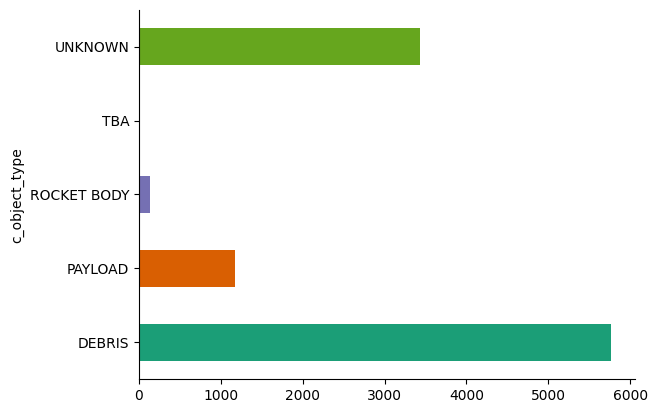

In [8]:
# @title c_object_type

from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('c_object_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
#convert Inclination from degrees to radians
def to_tensor(series):
    arr = series.values                     # <-- .values happens here
    if arr.max() > math.pi:  # likely in degrees
        arr = arr * math.pi / 180.0
    return torch.tensor(arr, dtype=torch.float32)

def normalize(tensor, mean=None, std=None):
    """
    Normalize tensor to mean=0, std=1.
    If mean/std are provided, use them (for test data).
    """
    if mean is None:
        mean = tensor.mean()
    if std is None:
        std = tensor.std()
    return (tensor - mean) / std, mean, std

# --- Prepare Tensors ---
# Training set
a_train_raw = torch.tensor(train_df['c_j2k_sma'].values, dtype=torch.float32)
e_train_raw = torch.tensor(train_df['c_j2k_ecc'].values, dtype=torch.float32)
I_train_raw = to_tensor(train_df['c_j2k_inc'])
P_train_raw = torch.tensor(train_df['risk'].values, dtype=torch.float32)

# Normalize inputs and output, and store means/stds for de-normalization
a_train, a_mean, a_std = normalize(a_train_raw)
e_train, e_mean, e_std = normalize(e_train_raw)
I_train, I_mean, I_std = normalize(I_train_raw)
P_train, P_mean, P_std = normalize(P_train_raw)

# Validation set (normalize with TRAIN means/stds!)
a_val_raw = torch.tensor(val_df['c_j2k_sma'].values, dtype=torch.float32)
e_val_raw = torch.tensor(val_df['c_j2k_ecc'].values, dtype=torch.float32)
I_val_raw = to_tensor(val_df['c_j2k_inc'])
P_val_raw = torch.tensor(val_df['risk'].values, dtype=torch.float32)

a_val = (a_val_raw - a_mean) / a_std
e_val = (e_val_raw - e_mean) / e_std
I_val = (I_val_raw - I_mean) / I_std
P_val = (P_val_raw - P_mean) / P_std

# Test set (normalize with TRAIN means/stds!)
a_test_raw = torch.tensor(test_df['c_j2k_sma'].values, dtype=torch.float32)
e_test_raw = torch.tensor(test_df['c_j2k_ecc'].values, dtype=torch.float32)
I_test_raw = to_tensor(test_df['c_j2k_inc'])
P_test_raw = torch.tensor(test_df['risk'].values, dtype=torch.float32)

a_test = (a_test_raw - a_mean) / a_std
e_test = (e_test_raw - e_mean) / e_std
I_test = (I_test_raw - I_mean) / I_std
P_test = (P_test_raw - P_mean) / P_std

print("Any NaNs in training data?", torch.isnan(a_train).any().item(),
      torch.isnan(e_train).any().item(),
      torch.isnan(I_train).any().item(),
      torch.isnan(P_train).any().item())


Any NaNs in training data? False False False False


In [10]:
# 2. Define Model
# --------------------
class PINN_P(nn.Module):
    def __init__(self, w=128, d=4):
        super().__init__()
        layers = []
        dims = [3] + [w]*d + [1]
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:
                layers.append(nn.Tanh())
        self.net = nn.Sequential(*layers)

    def forward(self, a, e, I):
        x = torch.stack([a, e, I], dim=-1)
        return self.net(x).squeeze(-1)

# --------------------
# 3. Physics Equations
# --------------------
def U_from_aeI(a, e, I, eps=1e-8):
    """Calculates total relative velocity U from Equation (2)."""
    sqrt_inner = torch.clamp(a * (1 - e**2), min=0.0)
    term = 3 - 1.0 / torch.clamp(a, min=eps) - 2 * torch.sqrt(sqrt_inner) * torch.cos(I)
    term = torch.clamp(term, min=0.0)
    return torch.sqrt(term)

def Ux_from_ae(a, e, eps=1e-8):
    """Calculates the x-component of relative velocity Ux."""
    term = 2 - 1.0 / torch.clamp(a, min=eps) - a * (1 - e**2)
    term = torch.clamp(term, min=0.0)
    return torch.sqrt(term)

def physics_residual(P_pred, a, e, I, eps=1e-8):
    """
    Calculates the residual of the physics equation (P_pred - P_physics).
    IMPORTANT: This function must be called with DE-NORMALIZED data.
    """
    U_calc = U_from_aeI(a, e, I, eps)
    Ux_calc = Ux_from_ae(a, e, eps)

    denom = (2 * math.pi**2) * torch.clamp(a, min=eps)**1.5 * (Ux_calc + eps) * (torch.abs(torch.sin(I)) + eps)
    P_phys = U_calc / denom

    return P_pred - P_phys

# --------------------
# 4. Train
# --------------------
model = PINN_P()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

# Adjusted lambda values for better initial training
lambda_phys, lambda_data = 1.0 , 1.0

n_epochs = 1000
loss_history = []
phys_history = []
data_history = []

for epoch in range(n_epochs):
    model.train()

    # 1. Forward pass on NORMALIZED data
    P_pred_norm = model(a_train, e_train, I_train)

    # 2. Calculate data loss on NORMALIZED data
    loss_data = torch.mean((P_pred_norm - P_train)**2)

    # 3. De-normalize inputs and predictions for physics loss
    a_train_denorm = a_train * a_std + a_mean
    e_train_denorm = e_train * e_std + e_mean
    I_train_denorm = I_train * I_std + I_mean
    P_pred_denorm = P_pred_norm * P_std + P_mean

    # 4. Calculate physics loss on DE-NORMALIZED data
    r_phys = physics_residual(P_pred_denorm, a_train_denorm, e_train_denorm, I_train_denorm)
    loss_phys = torch.mean(r_phys**2)

    # 5. Combine losses and backpropagate
    loss = lambda_phys * loss_phys + lambda_data * loss_data

    opt.zero_grad()
    loss.backward()
    opt.step()

    # --- Validation ---
    model.eval()
    with torch.no_grad():
        P_val_pred_norm = model(a_val, e_val, I_val)
        val_data_loss = torch.mean((P_val_pred_norm - P_val)**2)

        # De-normalize validation data for physics loss
        a_val_denorm = a_val * a_std + a_mean
        e_val_denorm = e_val * e_std + e_mean
        I_val_denorm = I_val * I_std + I_mean
        P_val_pred_denorm = P_val_pred_norm * P_std + P_mean

        r_phys_val = physics_residual(P_val_pred_denorm, a_val_denorm, e_val_denorm, I_val_denorm)
        val_phys_loss = torch.mean(r_phys_val**2)
        val_loss = lambda_phys * val_phys_loss + lambda_data * val_data_loss

    loss_history.append(loss.item())
    phys_history.append(loss_phys.item())
    data_history.append(loss_data.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: "
              f"train_loss={loss.item():.6f}, val_loss={val_loss.item():.6f}, "
              f"train_phys={loss_phys.item():.6f}, val_phys={val_phys_loss.item():.6f}, "
              f"train_data={loss_data.item():.6f}, val_data={val_data_loss.item():.6f}")

# --------------------
# 5. Evaluate on Test Set
# --------------------
model.eval()
with torch.no_grad():
    P_test_pred_norm = model(a_test, e_test, I_test)

    # Calculate test data loss on normalized values
    test_data_error = torch.mean((P_test_pred_norm - P_test)**2).item()
    print(f"\nTest Data MSE (normalized): {test_data_error:.6f}")

    # De-normalize test data for physics residual calculation
    a_test_denorm = a_test * a_std + a_mean
    e_test_denorm = e_test * e_std + e_mean
    I_test_denorm = I_test * I_std + I_mean
    P_test_pred_denorm = P_test_pred_norm * P_std + P_mean

    r_phys_test = physics_residual(P_test_pred_denorm, a_test_denorm, e_test_denorm, I_test_denorm)
    test_phys_error = torch.mean(r_phys_test**2).item()
    print(f"Test Physics Residual MSE (de-normalized): {test_phys_error:.6f}")


Epoch 0: train_loss=2619.112061, val_loss=2652.862061, train_phys=2618.105469, val_phys=2651.854248, train_data=1.006540, val_data=1.007922
Epoch 100: train_loss=446.269836, val_loss=442.510406, train_phys=427.826965, val_phys=423.728302, train_data=18.442877, val_data=18.782093
Epoch 200: train_loss=318.756165, val_loss=314.669250, train_phys=295.860596, val_phys=291.579498, train_data=22.895582, val_data=23.089760
Epoch 300: train_loss=202.248245, val_loss=198.482758, train_phys=178.064941, val_phys=173.981110, train_data=24.183308, val_data=24.501654
Epoch 400: train_loss=96.300919, val_loss=92.769035, train_phys=69.916199, val_phys=65.900253, train_data=26.384716, val_data=26.868782
Epoch 500: train_loss=59.601444, val_loss=56.192371, train_phys=31.553564, val_phys=27.576849, train_data=28.047880, val_data=28.615522
Epoch 600: train_loss=51.008327, val_loss=47.865746, train_phys=22.399904, val_phys=18.666986, train_data=28.608423, val_data=29.198759
Epoch 700: train_loss=47.814674,

In [11]:
print("Raw P_train range:", P_train.min().item(), P_train.max().item())
print("Raw P_test range:", P_test.min().item(), P_test.max().item())


Raw P_train range: -0.7092346549034119 2.284766912460327
Raw P_test range: -0.7092346549034119 2.1570935249328613


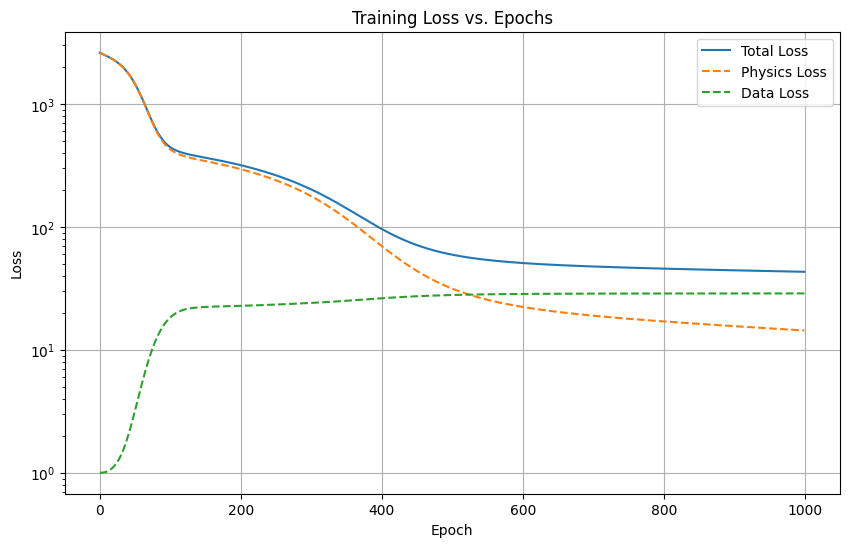

In [12]:
# 6. Save Model and Plot Results
# --------------------
torch.save(model.state_dict(), "pinn_P_trained_corrected.pth")

# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label="Total Loss")
plt.plot(phys_history, label="Physics Loss", linestyle='--')
plt.plot(data_history, label="Data Loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.yscale('log') # Use log scale for better visibility
plt.show()

# De-normalize test predictions and true labels for scatter plot
P_test_true_denorm = P_test * P_std + P_mean
# P_test_pred_denorm is already calculated above


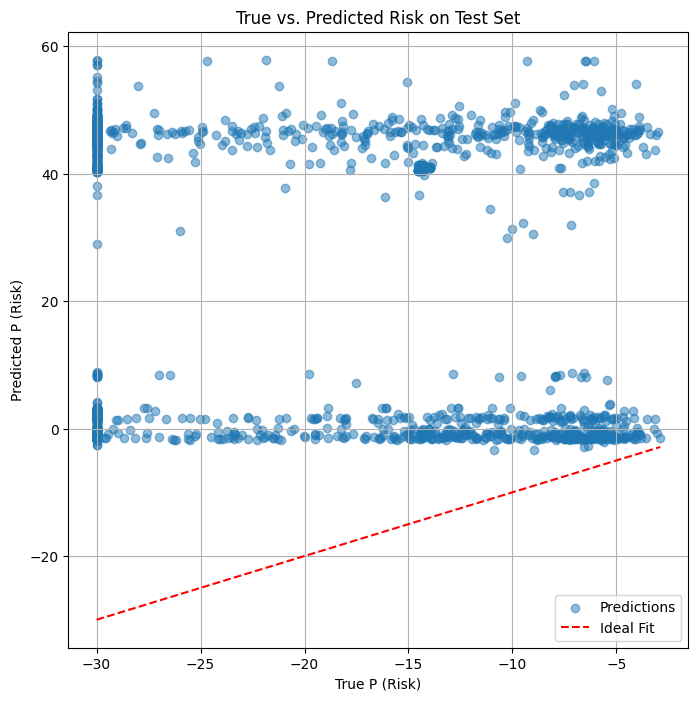

In [13]:
plt.figure(figsize=(8, 8))
plt.scatter(P_test_true_denorm.numpy(), P_test_pred_denorm.numpy(), alpha=0.5, label="Predictions")
plt.plot([P_test_true_denorm.min(), P_test_true_denorm.max()],
         [P_test_true_denorm.min(), P_test_true_denorm.max()],
         'r--', label="Ideal Fit")
plt.xlabel("True P (Risk)")
plt.ylabel("Predicted P (Risk)")
plt.title("True vs. Predicted Risk on Test Set")
plt.legend()
plt.grid(True)
plt.show()